In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# Validation, regularisation and callbacks

## Load the data

In [2]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [3]:
print(diabetes_dataset.keys())

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [4]:
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [5]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean()) / targets.std()

In [6]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

In [7]:
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


### Train a feedforward neural network model

In [8]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)        
    ])
    return model

model = get_model()

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [10]:
# Compile the model

model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [11]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [12]:
# Evaluate the model on the test data

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.8460 - mae: 0.8460


[0.8460189700126648, 0.8460189700126648]

### Plot the learning curves

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

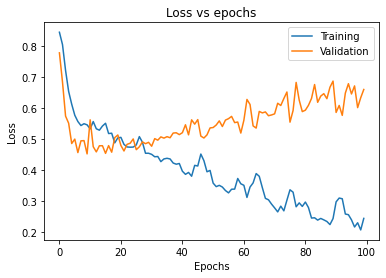

In [14]:
# Plot the training and valiation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

The model clearly overfits our training data, which makes it perform poorly on the validation set.

# Model regularisation

In [15]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [16]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu', input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
        Dropout(rate),
        Dense(1)        
    ])
    return model

In [17]:
model = get_regularised_model(1e-5, 0.3)

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [19]:
# Train the model, with some of the data reserved for valiation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [20]:
# Evaluate the model on the test_set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.6524 - mae: 0.6616


[0.6523677110671997, 0.6615796685218811]

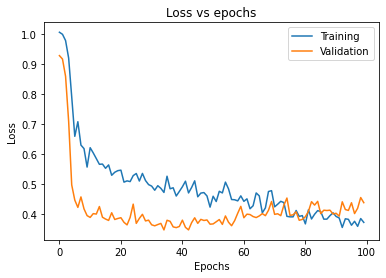

In [21]:
# Plot the training and valiation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Introduction to callbacks

In [24]:
# Write a custom callback for training

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print('Starting training...')
    
    def on_epochs_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs=None):
        print("Finished training!")

In [25]:
model = get_regularised_model(1e-5, 0.3)

In [26]:
model.compile(optimizer='adam', loss='mae')

In [28]:
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training...
Training: Starting batch 0
Training: Starting batch 1
Training: Starting batch 2
Training: Starting batch 3
Finished epoch 0
Training: Starting batch 0
Training: Starting batch 1
Training: Starting batch 2
Training: Starting batch 3
Finished epoch 1
Training: Starting batch 0
Training: Starting batch 1
Training: Starting batch 2
Training: Starting batch 3
Finished epoch 2
Finished training!


In [29]:
# Writing custom callbacks for testing

from tensorflow.keras.callbacks import Callback

class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print('Starting testing...')
        
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
        
    def on_test_end(self, logs=None):
        print("Finished testing!")

In [30]:
model = get_regularised_model(1e-5, 0.3)

In [31]:
model.compile(optimizer='adam', loss='mse')

In [32]:
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training...
Training: Starting batch 0
Training: Starting batch 1
Training: Starting batch 2
Training: Starting batch 3
Finished epoch 0
Training: Starting batch 0
Training: Starting batch 1
Training: Starting batch 2
Training: Starting batch 3
Finished epoch 1
Training: Starting batch 0
Training: Starting batch 1
Training: Starting batch 2
Training: Starting batch 3
Finished epoch 2
Finished training!


In [34]:
model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing...
Testing: Starting batch 0
Testing: Starting batch 1
Finished testing!


1.0410099029541016

In [35]:
# Writing a custom prediction callback

class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print('Start prediction')
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f'Prediction: Starting batch {batch}')
    
    def on_prediction_batch_end(self, batch, logs=None):
        print(f'Prediction: finished batch {batch}')
        
    def on_test_end(self, logs=None):
        print('Finished prediction!')

In [36]:
model = get_regularised_model(1e-5, 0.3)

In [37]:
model.compile(optimizer='adam', loss='mse')

In [38]:
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training...
Training: Starting batch 0
Training: Starting batch 1
Training: Starting batch 2
Training: Starting batch 3
Finished epoch 0
Training: Starting batch 0
Training: Starting batch 1
Training: Starting batch 2
Training: Starting batch 3
Finished epoch 1
Training: Starting batch 0
Training: Starting batch 1
Training: Starting batch 2
Training: Starting batch 3
Finished epoch 2
Finished training!


In [39]:
model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing...
Testing: Starting batch 0
Testing: Starting batch 1
Finished testing!


1.0601948499679565

In [41]:
model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Start prediction
Prediction: Starting batch 0
Prediction: Starting batch 1


array([[ 4.9049307e-02],
       [-3.0991659e-02],
       [-4.6343461e-02],
       [ 2.1236499e-03],
       [ 6.1014578e-02],
       [-4.2154908e-02],
       [ 2.9094882e-02],
       [ 2.5773691e-02],
       [-1.0462413e-02],
       [-2.6068932e-03],
       [-5.4162994e-02],
       [ 4.1607991e-02],
       [-2.7988835e-03],
       [ 8.5775508e-05],
       [ 2.6048619e-02],
       [-1.9789806e-03],
       [ 5.6607056e-02],
       [-2.6099958e-02],
       [ 8.8306718e-02],
       [ 3.5026912e-02],
       [-4.3330155e-02],
       [ 6.0023680e-02],
       [ 5.6448709e-02],
       [-4.6744319e-03],
       [-3.2497689e-02],
       [-5.6956716e-02],
       [ 8.2034403e-03],
       [ 5.3649977e-02],
       [ 6.4306855e-02],
       [-3.6499409e-03],
       [ 4.1412916e-02],
       [ 3.1335827e-02],
       [ 5.3204503e-02],
       [ 7.6263525e-02],
       [ 7.7540595e-03],
       [ 4.4709101e-02],
       [ 5.2958202e-02],
       [ 2.2390205e-02],
       [ 2.0913288e-02],
       [ 2.6381830e-02],


# Early stopping / patience

In [62]:
# Retrain the unregularized model

unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(train_data,
                                       train_targets,
                                       epochs=100,
                                       validation_split=0.15,
                                       batch_size=64,
                                       verbose=False,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

In [63]:
# Evaluate the model on the test data

unregularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.5310


0.5310240983963013

In [64]:
# Retrain the regularised model

regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam',
                         loss='mse')
reg_history = regularised_model.fit(train_data,
                                   train_targets,
                                   epochs=100,
                                   validation_split=0.15, 
                                   batch_size=64,
                                   verbose=False,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

In [65]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.5536


0.5535891056060791

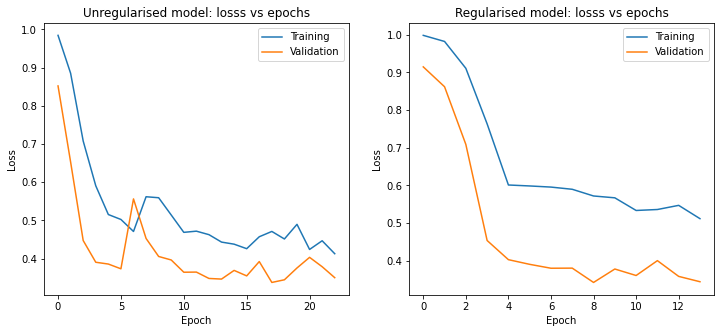

In [66]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: losss vs epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: losss vs epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()